In [1]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import linregress

import mtspec

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors

%load_ext autoreload
%autoreload 2

In [2]:
from defs import EOF_SST_analysis, trim_axs, Nino34_timeseries, Nino_timeseries, Zonal_SST_gradient

In [75]:
## Figure settings

import matplotlib.pylab as pylab

figwidth1 = 8.3;
figwidth2 = 12;

r = figwidth2/figwidth1;

params1 = {'legend.fontsize':15,
         'axes.labelsize':16.5,
         'axes.titlesize':14.5,
         'xtick.labelsize':14.5,
         'ytick.labelsize':14.5}

params2 = {'legend.fontsize':14.5,
         'axes.labelsize':15.5,
         'axes.titlesize':16.5,
         'xtick.labelsize':14.5,
         'ytick.labelsize':14.5}

cmap_temp = plt.get_cmap('cmo.thermal');
cmap_div  = plt.get_cmap('cmo.balance');
cmap_diff = plt.get_cmap('RdBu_r');

# pylab.rcParams.update(params)

## Load HadISST observations

In [4]:
## HadISST data
## https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html
## 1870 - 2020 SST data

file = 'observations/HadISST/HadISST_sst.nc'
ds   = xr.open_dataset(file)

# select last 100 years
ds = ds.sel(time=slice("1920", "2019"))

# -180 to 180 transform to 0 - 360
ds.coords['longitude'] = (ds.coords['longitude'] - 360) % 360
ds = ds.sortby(ds.longitude)
ds = ds.sortby(ds.latitude)

# select tropical pacific
minlat = -23;  maxlat = 23; minlon = 140; maxlon = 280;
ds = ds.sel(latitude = slice(minlat, maxlat)).sel(longitude = slice(minlon, maxlon))

# Nino3.4 index
Nino4_hadisst = ds.sst.where(ds.latitude<5).where(ds.latitude>-5).where(ds.longitude>160).where(ds.longitude<210).mean(dim='latitude').mean(dim='longitude')
Nino4_hadisst = Nino4_hadisst.groupby('time.month') - Nino4_hadisst.groupby('time.month').mean(dim='time')

Nino34_hadisst = ds.sst.where(ds.latitude<5).where(ds.latitude>-5).where(ds.longitude>190).where(ds.longitude<240).mean(dim='latitude').mean(dim='longitude')
Nino34_hadisst = Nino34_hadisst.groupby('time.month') - Nino34_hadisst.groupby('time.month').mean(dim='time')

Nino3_hadisst = ds.sst.where(ds.latitude<5).where(ds.latitude>-5).where(ds.longitude>210).where(ds.longitude<270).mean(dim='latitude').mean(dim='longitude')
Nino3_hadisst = Nino3_hadisst.groupby('time.month') - Nino3_hadisst.groupby('time.month').mean(dim='time')

Nino12_hadisst = ds.sst.where(ds.latitude<0).where(ds.latitude>-10).where(ds.longitude>270).where(ds.longitude<280).mean(dim='latitude').mean(dim='longitude')
Nino12_hadisst = Nino12_hadisst.groupby('time.month') - Nino12_hadisst.groupby('time.month').mean(dim='time')

# eofs, without climatology
n = 1
ssts = ds.sst.groupby('time.month') - ds.sst.groupby('time.month').mean(dim='time')

fit = np.zeros([len(ssts["time"]), len(ssts["latitude"]), len(ssts["longitude"])])
t = range(len(ssts["time"]))
for i in range(len(ssts["latitude"])):
    for j in range(len(ssts["longitude"])):
        p = np.polyfit(t, ssts[:,i,j], 1)
        l = t*p[0] + p[1]
        fit[:,i,j] = ssts[:,i,j] - l    
ssts = xr.DataArray(data=fit, dims=["time", "latitude", "longitude"],
                    coords=dict(time=(["time"], ssts["time"]), latitude=(["latitude"], ssts["latitude"]), 
                                         longitude=(["longitude"], ssts["longitude"])))

solver = Eof(ssts, weights=None, center=True)
eofs = solver.eofsAsCovariance(neofs=n)
pcs  = solver.pcs(npcs=n, pcscaling=1)
varF = solver.varianceFraction(neigs=n)
hadisst_eofs = xr.merge([eofs, pcs, varF])

hadisst_varf = hadisst_eofs.variance_fractions.isel(mode=0).values
eof_hadisst = hadisst_eofs.eofs.isel(mode=0)

minlat = -5;  maxlat = 5; minlon = 190; maxlon = 240; #Nino3.4
mean = eof_hadisst.sel(latitude = slice(minlat, maxlat)).sel(longitude = slice(minlon, maxlon)).mean(dim='latitude').mean(dim='longitude')
if mean<0: eof_hadisst = -eof_hadisst;

eof_hadisst = eof_hadisst/np.std(eof_hadisst)

# correlation of Nino3.4 with PC1
PC = hadisst_eofs.pcs.isel(mode=0)
hadisst_corr4  = np.abs(np.corrcoef(Nino4_hadisst.values, PC.values)[0,1])
hadisst_corr34 = np.abs(np.corrcoef(Nino34_hadisst.values, PC.values)[0,1])
hadisst_corr3  = np.abs(np.corrcoef(Nino3_hadisst.values, PC.values)[0,1])
hadisst_corr12 = np.abs(np.corrcoef(Nino12_hadisst.values, PC.values)[0,1])
hadisst_corr = hadisst_corr34;


### PlioMIP1 data

In [5]:
## Import Brierley figure 8 
# extracted via WebPlotDigitizer & via contact with Chris
#
# x = Change-ENSO pattern correlation
# y = ENSO amplitude change (%)

P1_models  = ['CCSM4', 'COSMOS', 'FGOALS-g2', 'GISS-E2-R', 'HadCM3', 'IPSLCM5A', 'MIROC4m', 'MRI2.3', 'NorESM-L']
P1_pi_sd   = np.array([1.02, 1.79, 0.61, 0.47, 0.71, 0.61, 0.47, 0.67, 0.69])
P1_plio_sd = np.array([0.84, 1.44, 0.44, 0.43, 0.57, 0.54, 0.31, 0.67, 0.31])
P1_sd_change = 100*(P1_plio_sd - P1_pi_sd)/P1_pi_sd;
P1_corr_change = np.array([-0.28, 0.45, 0.09, -0.37, -0.28, -0.20, 0.01, 0., 0.32])


## load Model data

In [6]:
modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 'CESM2', 'COSMOS', 'EC-Earth3.3',
             'GISS2.1G', 'HadCM3', 'HadGEM3', 'IPSLCM5A', 'IPSLCM5A2', 'IPSLCM6A', 'MIROC4m', 
             'MRI2.3', 'NorESM-L', 'NorESM1-F']


## EOF analysis

# **Appendix Figure 3**

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

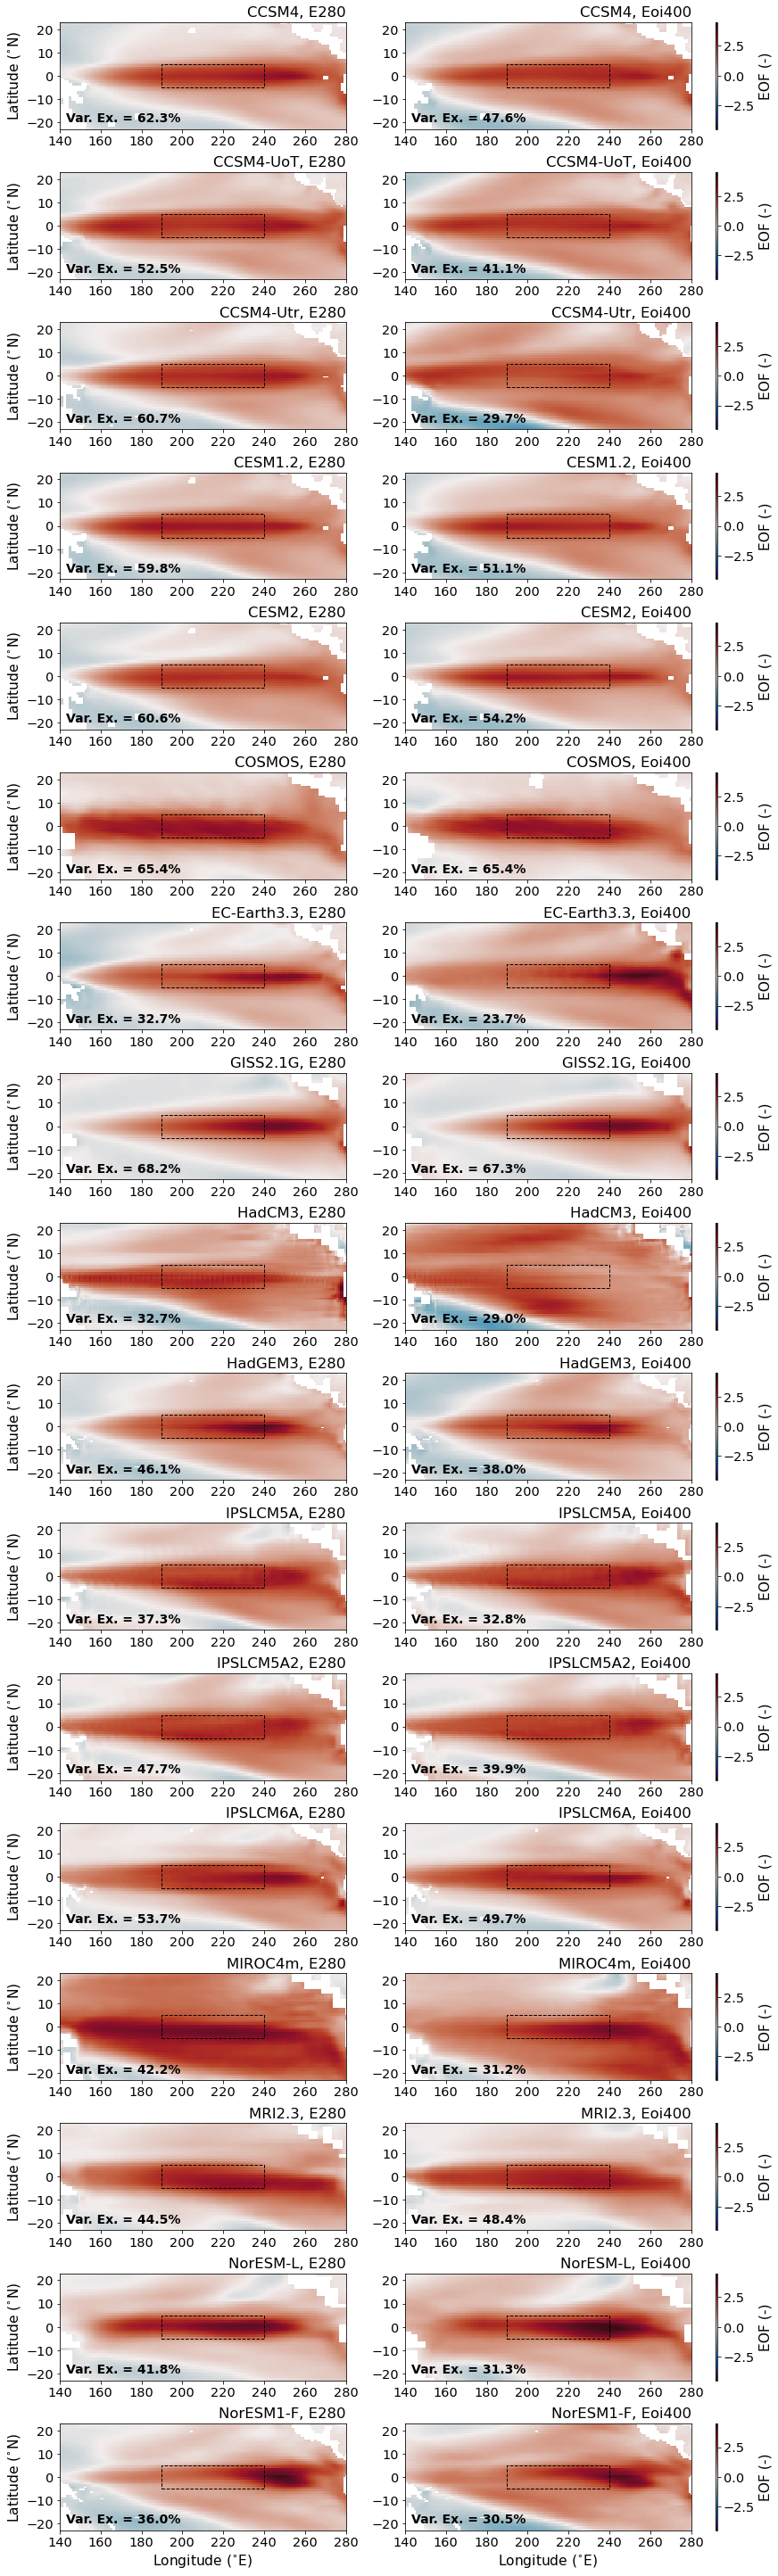

In [14]:
# select 'figtype': 'first8' for Fig S3, 'last9' for Fig S3 (cont.)
#
# NOTE this code can take a long time to run!! +-20mins

figtype = 'all'

if figtype == 'all':
    N_models = len(modellist);    
    skip = 0;
    figlen = 40;
elif figtype == 'first8':
    N_models = 9;
    skip = -1;
    figlen = 20;
elif figtype == 'last9':
    N_models = 9;
    skip = 8;
    figlen = 20;    
    
trendtype = "linear"    

vmin = -4.5; vmax = 4.5; 

pylab.rcParams.update(params2)
fig1, axs = plt.subplots(nrows = N_models, ncols=2, figsize=(figwidth2, figlen), constrained_layout=True)
axs = trim_axs(axs, 2*N_models)

if figtype == 'all':
    varf_e280   = np.zeros(N_models)
    varf_eoi400 = np.zeros(N_models)
#     corr_e280   = np.zeros((N_models,4))
#     corr_eoi400 = np.zeros((N_models,4))

for ax, i in zip(axs, range(2*N_models)):

    if np.mod(i,2)==0:   run = 'E280'
    elif np.mod(i,2)==1: run = 'EOI400'

    i_model = skip + np.int(np.floor(i/2)) 
    
    if figtype=='first8' and i==0:
        eof1 = eof_hadisst
        varf = hadisst_varf
        title = 'HadISST 1920-2020'
    else:
        model = modellist[i_model]

        eofs = EOF_SST_analysis(model, run, weights=None, n=1, trend=trendtype)
        eof1 = eofs.eofs.isel(mode=0)

        #define EOF so that it is positive in the Nino3.4 region
        minlat = -5;  maxlat = 5; minlon = 190; maxlon = 240; #Nino3.4
        mean = eof1.sel(latitude = slice(minlat, maxlat)).sel(longitude = slice(minlon, maxlon)).mean(dim='latitude').mean(dim='longitude')
        if mean<0: eof1 = -eof1;

        #normalise by spatial std dev
        eof1 = eof1 / eof1.std()

        # calculate variance fraction and include in plot    
        varf = eofs.variance_fractions.isel(mode=0).values
        
        if run=='EOI400': run2 = 'Eoi400';
        else: run2 = run;
        title = f'{model}, {run2}'
    
    # plot
    if figtype=='first8' and i==0:
        eof1.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap_div, add_colorbar=False)
        ax.set_ylabel('Latitude ($^{\circ}$N)')
    elif figtype=='first8' and i==1:
        eof1.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap_div, add_colorbar=False)
        ax.set_ylabel('')
    elif np.mod(i,2)==0:
        eof1.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap_div, add_colorbar=False)
        ax.set_ylabel('Latitude ($^{\circ}$N)')
    else:
        eof1.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap_div, add_colorbar=True, cbar_kwargs = dict(label='EOF (-)'))
        ax.set_ylabel('')
    
    ax.set_xlim(140,280)
    ax.set_ylim(-23,23)
    ax.set_yticks([-20,-10,0,10,20])
    if i>2*N_models-3: ax.set_xlabel('Longitude ($^{\circ}$E)')
    else: ax.set_xlabel('')

    ax.set_title(title, loc='right')
    ax.set_title('')
    
    # draw Nino3.4 region
    ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));
    ax.text(143, -20, f'Var. Ex. = {100*varf:.1f}%', fontsize = 14, fontweight = 'bold')
    
    if figtype == 'first8' and i==1:
        ax.clear()
        ax.axis('off')
    
#     #calculate correlation of Nino3.4 index with PC1
#     PC   = eofs.pcs.isel(mode=0)   
#     nino4  = Nino_timeseries(model, run, mode='Nino4')
#     nino34 = Nino_timeseries(model, run, mode='Nino34')
#     nino3  = Nino_timeseries(model, run, mode='Nino3')
#     nino12 = Nino_timeseries(model, run, mode='Nino12')
    
#     corr4  = np.abs(np.corrcoef(nino4.values, PC.values[:1200])[0,1])
#     corr34 = np.abs(np.corrcoef(nino34.values, PC.values[:1200])[0,1])
#     corr3  = np.abs(np.corrcoef(nino3.values, PC.values[:1200])[0,1])
#     corr12 = np.abs(np.corrcoef(nino12.values, PC.values[:1200])[0,1])
#     corr   = [corr4, corr34, corr3, corr12]

    if figtype == 'all':
        
        # save for mean EOF
        if i_model==0: 
            if run=='E280':     
                eof1_e280 = eof1; 
                poscount_e280 = 1*(eof1>0); # 'count' what the sign of the EOF is - needed for Fig 5 stippling
            elif run=='EOI400': 
                eof1_eoi400 = eof1; 
                poscount_eoi400 = 1*(eof1>0);
        else:
            if run=='E280':     
                eof1_e280 = eof1_e280 + eof1.values;
                poscount_e280 = poscount_e280 + 1*(eof1>0).values;            
            elif run=='EOI400': 
                eof1_eoi400 = eof1_eoi400 + eof1.values;
                poscount_eoi400 = poscount_eoi400 + 1*(eof1>0).values; 

        if run=='E280':
            eof_old = eof1;
        elif run=='EOI400':
            diff = eof1 - eof_old;
            if i_model==0:
                poscount_diff = 1*(diff>0);
            else:
                poscount_diff = poscount_diff + 1*(diff>0).values;        

        # save varF & corr
        if run=='E280':
            varf_e280[i_model]   = varf
#             corr_e280[i_model,:]   = corr
        elif run=='EOI400':
            varf_eoi400[i_model] = varf
#             corr_eoi400[i_model,:] = corr

if figtype == 'all':        
    # save final data
    EM_eof1_e280   = eof1_e280/len(modellist)
    EM_eof1_eoi400 = eof1_eoi400/len(modellist)
    EM_varf_e280   = np.mean(varf_e280)
    EM_varf_eoi400 = np.mean(varf_eoi400)
#     EM_corr_e280   = np.mean(corr_e280, axis=0)
#     EM_corr_eoi400 = np.mean(corr_eoi400, axis=0)
                
# plt.savefig('figures/first_eofs_v3.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/appendixfigure3a_new.pdf', bbox_inches='tight')

# **Figure 5**

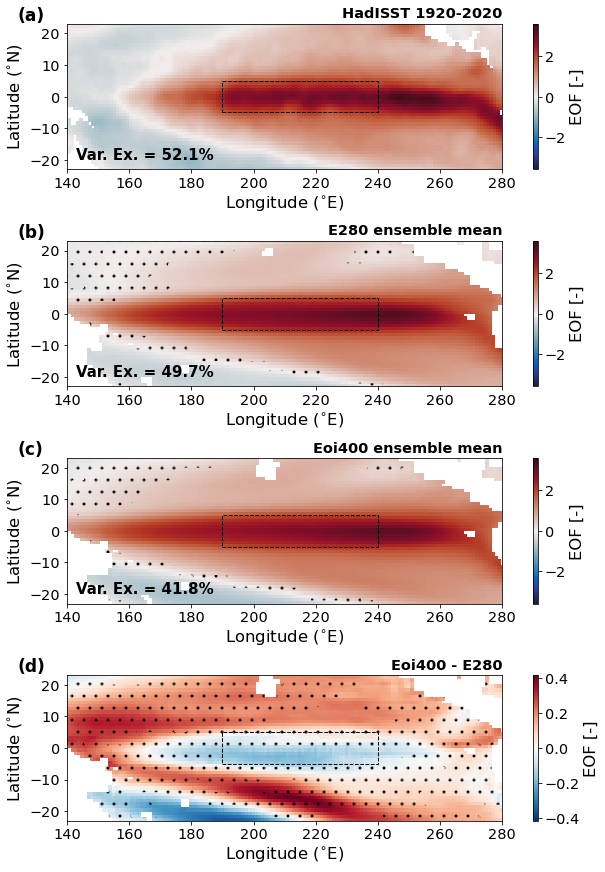

In [76]:
pylab.rcParams.update(params1)
fig2, axs = plt.subplots(nrows=4, ncols=1, figsize=(figwidth1, 12), constrained_layout=True)

caption = True;
textx = 124; texty = 24; 

plt.rcParams['hatch.linewidth'] = 0.5;
plt.rcParams['pcolor.shading'] = 'auto'

lats = [-23, 23]
lons = [140, 280]

vmin = -3.6; vmax = 3.6; 

a = EM_eof1_e280
b = EM_eof1_eoi400

d = 5; # stippling included when more than d models do not agree on the sign of the EOF
hatching = '.';

ax=axs[0]
(eof_hadisst).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap_div, cbar_kwargs = dict(label='EOF [-]'))
ax.set_title('HadISST 1920-2020', loc='right', fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)')
ax.set_ylabel('Latitude ($^{\circ}$N)')
ax.set_title('')
ax.text(143, -20, f'Var. Ex. = {100*hadisst_varf:.1f}%', fontweight = 'bold', fontsize=15)
ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));
if caption == True: ax.text(textx, texty, '(a)', fontsize = 17, fontweight = 'bold')

ax=axs[1]
p = a.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap_div, cbar_kwargs = dict(label='EOF [-]'))
ax.set_title('E280 ensemble mean', loc='right', fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)')
ax.set_ylabel('Latitude ($^{\circ}$N)')
ax.set_title('')
ax.text(143, -20, f'Var. Ex. = {100*EM_varf_e280:.1f}%', fontweight = 'bold', fontsize=15)
ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));

y1 = np.ma.masked_where((poscount_e280.values>len(modellist)-d), poscount_e280.values)
y2 = np.ma.masked_where((poscount_e280.values<d+1), poscount_e280.values)
g=np.ma.masked_where(a==np.nan, a)
ax.pcolor(poscount_e280.longitude, poscount_e280.latitude, y1*y2*g, alpha=0., hatch=hatching)
if caption == True: ax.text(textx, texty, '(b)', fontsize = 17, fontweight = 'bold')

ax=axs[2]
b.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap_div, cbar_kwargs = dict(label='EOF [-]'))
ax.set_title('Eoi400 ensemble mean', loc='right', fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)')
ax.set_ylabel('Latitude ($^{\circ}$N)')
ax.set_title('')
ax.text(143, -20, f'Var. Ex. = {100*EM_varf_eoi400:.1f}%', fontweight = 'bold', fontsize=15)
ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));

y1 = np.ma.masked_where((poscount_eoi400.values>len(modellist)-d), poscount_eoi400.values)
y2 = np.ma.masked_where((poscount_eoi400.values<d+1), poscount_eoi400.values)
g=np.ma.masked_where(b==np.nan, b)
ax.pcolor(poscount_e280.longitude, poscount_e280.latitude, y1*y2*g, alpha=0., hatch=hatching)
if caption == True: ax.text(textx, texty, '(c)', fontsize = 17, fontweight = 'bold')

ax=axs[3]
(b-a).plot(ax=ax, cmap=cmap_diff, cbar_kwargs = dict(label='EOF [-]'))
ax.set_title('Eoi400 - E280', loc='right',  fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)')
ax.set_ylabel('Latitude ($^{\circ}$N)')
ax.set_title('')
ax.add_patch(Rectangle((190,-5),50,10, fill=False, linestyle='--'));

y1 = np.ma.masked_where((poscount_diff.values>len(modellist)-d), poscount_diff.values)
y2 = np.ma.masked_where((poscount_diff.values<d+1), poscount_diff.values)
g=np.ma.masked_where((b-a)==np.nan, (b-a))
ax.pcolor(poscount_e280.longitude, poscount_e280.latitude, y1*y2*g, alpha=0., hatch=hatching)
if caption == True: ax.text(textx, texty, '(d)', fontsize = 17, fontweight = 'bold')

# plt.savefig('figures/mean_eofs_v3.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/mean_eofs_v4.pdf', bbox_inches='tight')
plt.savefig('figures/figure5.pdf', bbox_inches='tight')

### Calculate Nino3.4 std

In [44]:
## Calculate Nino34 index time series & standard deviation

std_e280    = np.zeros(len(modellist))
std_eoi400  = np.zeros(len(modellist))

trend_type = "linear" # linear detrending of Nino34 series

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
    
    ds = Nino34_timeseries(model = modellist[i], run='E280', trend = trend_type)
    if i==0: 
        nino_e280   = np.zeros((len(ds), len(modellist)))    
        nino_eoi400 = np.zeros((len(ds), len(modellist))) 
        
    nino_e280[:,i]   = ds
    nino_eoi400[:,i] = Nino34_timeseries(model = modellist[i], run='EOI400', trend = trend_type)
    
    std_e280[i]    = np.std(nino_e280[:,i])
    std_eoi400[i]  = np.std(nino_eoi400[:,i])    

model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = CESM1.2
model = CESM2
model = COSMOS


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = EC-Earth3.3


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


In [45]:
## Correlation of the Annual Mean SST change with the leading E280 EOF

Ninolike        = np.zeros(len(modellist))

for i in range(len(modellist)):

    model = modellist[i]
    print(model)

    run = 'E280'
    EOF1 = EOF_SST_analysis(model, run, weights = None, n = 1).eofs.isel(mode=0)
    #define EOF so that it is positive in the Nino3.4 region
    mean = EOF1.where(EOF1.latitude>-5).where(EOF1.latitude<5).where(EOF1.longitude>190).where(EOF1.longitude<240).mean(dim='latitude').mean(dim='longitude')
    if mean < 0: EOF1 = -EOF1.values;
    else: EOF1 = EOF1.values
    
    AMT1 = Zonal_SST_gradient(model, run, latbound = 23, latmean=False).values
    AMT1 = (AMT1 - np.nanmean(AMT1))/np.nanstd(AMT1)

    run = 'Eoi400'
    EOF2 = EOF_SST_analysis(model, run, weights = None, n = 1).eofs.isel(mode=0)
    #define EOF so that it is positive in the Nino3.4 region
    mean = EOF2.where(EOF2.latitude>-5).where(EOF2.latitude<5).where(EOF2.longitude>190).where(EOF2.longitude<240).mean(dim='latitude').mean(dim='longitude')
    if mean < 0: EOF2 = -EOF2.values;
    else: EOF2 = EOF2.values
            
    AMT2 = Zonal_SST_gradient(model, run, latbound = 23, latmean=False).values
    AMT2 = (AMT2 - np.nanmean(AMT2))/np.nanstd(AMT2)
    
    ## correlate annual mean change (eoi400 - e280) to E280 leading EOF:
    Ninolike[i] = np.corrcoef((AMT2-AMT1)[~np.isnan(AMT2-AMT1)], EOF1[~np.isnan(AMT2-AMT1)])[0,1]


CCSM4
CCSM4-UoT
CCSM4-Utr


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CESM1.2
CESM2
COSMOS


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarra

EC-Earth3.3


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/py

GISS2.1G
HadCM3
HadGEM3
IPSLCM5A
IPSLCM5A2
IPSLCM6A


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


MIROC4m
MRI2.3
NorESM-L
NorESM1-F


# **Figure 10**

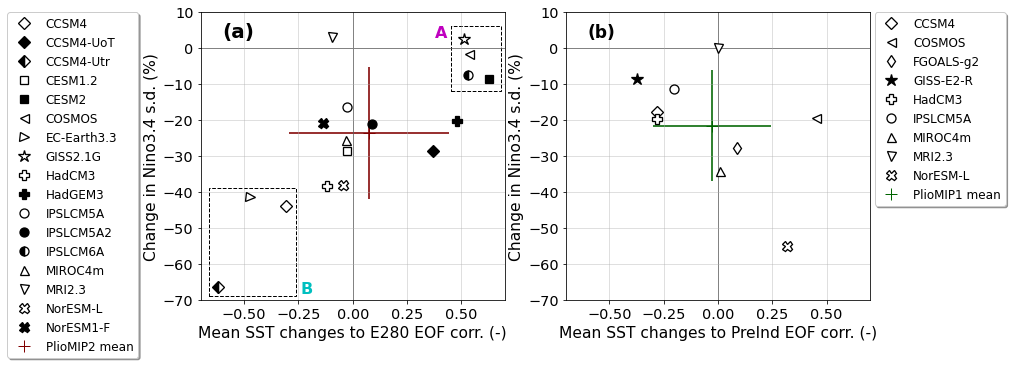

In [72]:
pylab.rcParams.update(params2)
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(figwidth2, 5.3))

caption=True;

ax=axs[0]

x = Ninolike
y = 100*(std_eoi400 - std_e280)/std_e280
xlims = [-0.7, 0.7]; ylims = [-70, 10];

markers = ['D', 'D', 'D', 's', 's', '<', '>', '*', 'P', 'P', 'o', 'o', 'o', '^', 'v', 'X', 'X']
msize   = [8,    8,   8,   8,   8,   9,   9,  13,  10,   10,   9,   9,   9,   9,   9,  10,  10]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'k', 'w', 'k', 'w', 'w', 'w', 'w', 'k']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 
              'full', 'right', 'full', 'full', 'full', 'full']

for i in range(len(modellist)):
    ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
    markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

emcolor = 'maroon'
ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'PlioMIP2 mean', zorder=-1, alpha=1)    
ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
    '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
    '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)   
    
# grid
ax.grid(alpha=0.5);
# ax.plot(xlims, xlims,'k:', alpha=0.8, zorder = -1);
ax.plot(xlims, [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.plot([0,0], ylims, 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.set_xlim(xlims); ax.set_ylim(ylims)

ax.legend(loc='upper center', bbox_to_anchor=(-.42, 1.02), shadow=True, ncol=1, fontsize=12)
ax.set_ylabel('Change in Nino3.4 s.d. (%)'); 
ax.set_xlabel('Mean SST changes to E280 EOF corr. (-)');

ax.add_patch(Rectangle((0.45,-12),0.23,18, fill=False, linestyle='--'));
ax.text(0.38, 3, 'A', fontsize=16, fontweight='bold', color='m')

ax.add_patch(Rectangle((-0.66,-69),0.40,30, fill=False, linestyle='--'));
ax.text(-0.24, -68, 'B', fontsize=16, fontweight='bold', color='c')

if caption==True: ax.text(-0.6, 3, '(a)', fontsize=20, fontweight ='bold')

ax=axs[1]

markers = ['D',  '<', 'd', '*', 'P', 'o',  '^', 'v', 'X']
msize   = [8,     9,   9,  13,  10,   9,    9,   9,   10]
colors  = ['w',  'w', 'w', 'k', 'w', 'w',  'w', 'w', 'w']
fillstyles = ['full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full']

x = P1_corr_change; y= P1_sd_change;
for i in range(len(P1_models)):
    ax.plot(x[i], y[i], label = P1_models[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
    markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
    
    
## PlioMIP1
col = 'darkgreen'; emcolor=col;
ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'PlioMIP1 mean', zorder=-1, alpha=1)    
ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
    '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
    '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)         
    
# grid
ax.grid(alpha=0.5);
# ax.plot(xlims, xlims,'k:', alpha=0.8, zorder = -1);
ax.plot(xlims, [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.plot([0,0], ylims, 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.set_xlim(xlims); ax.set_ylim(ylims)

ax.legend(loc='upper center', bbox_to_anchor=(1.23, 1.02), shadow=True, ncol=1, fontsize=12)

ax.set_ylabel('Change in Nino3.4 s.d. (%)'); 
ax.set_xlabel('Mean SST changes to PreInd EOF corr. (-)');

if caption==True: ax.text(-0.6, 3, '(b)', fontsize=17, fontweight ='bold')

plt.savefig('figures/figure10.pdf', bbox_inches='tight')

### El Nino-like cluster vs. La Nina-like cluster

In [77]:
modelsA_ = ['CESM2', 'COSMOS', 'GISS2.1G', 'IPSLCM6A']
modelsB_ = ['CCSM4', 'CCSM4-Utr', 'EC-Earth3.3']

# select cluster
cluster = 'B';

if cluster == 'A':
    models_ = modelsA_
elif cluster == 'B':
    models_ = modelsB_

latbounds = 23

for i in range(len(models_)):
    model = models_[i]

    run = 'E280'
    EOF1 = EOF_SST_analysis(model, run, latbound = latbounds, weights = None, n = 1).eofs.isel(mode=0)
    #define EOF so that it is positive in the Nino3.4 region
    mean = EOF1.where(EOF1.latitude>-5).where(EOF1.latitude<5).where(EOF1.longitude>190).where(EOF1.longitude<240).mean(dim='latitude').mean(dim='longitude')
    if mean < 0: EOF1 = -EOF1.values;
    else: EOF1 = EOF1.values

    AMT1 = Zonal_SST_gradient(model, run, latbound = latbounds, latmean=False).values

    run = 'Eoi400'
    AMT2 = Zonal_SST_gradient(model, run, latbound = latbounds, latmean=False).values
    
    # save for mean temperature difference and mean EOF
    if i==0: 
        tempdiff = AMT2 - AMT1
        PIeof    = EOF1
    else:
        tempdiff = tempdiff + (AMT2 - AMT1)
        PIeof    = PIeof + EOF1

if cluster == 'A':
    tempdiff1 = tempdiff/len(modelsA_)
    PIeof1    = PIeof/len(modelsA_)
elif cluster == 'B':
    tempdiff2 = tempdiff/len(modelsB_)
    PIeof2    = PIeof/len(modelsB_)


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarra

# **Figure 11**

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
<ipython-input-70-5ea79260172b>:21: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(hspace=.5, wspace=.15)


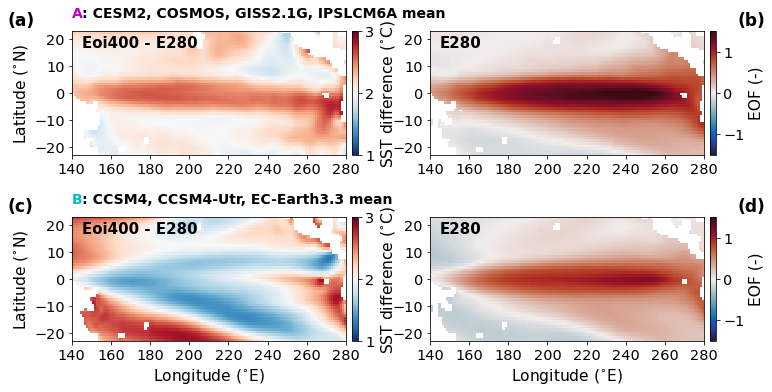

In [70]:
# load a 'random' zsg for the lons and lats
A = Zonal_SST_gradient(model, run, latbound = latbounds, latmean=False)
x = A.longitude.values; y = A.latitude.values;

caption = True;
textx = [107, 297, 107, 297]; texty = [25, 25, 25, 25]; textlist = ['(a)', '(b)', '(c)', '(d)'];

zlist = [tempdiff1, PIeof1, tempdiff2, PIeof2]

titles = [': CESM2, COSMOS, GISS2.1G, IPSLCM6A mean',': CCSM4, CCSM4-Utr, EC-Earth3.3 mean'] #,  'CCSM4-UoT, HadGEM3 mean']
titles1 = ['A', 'B']; colors = ['m', 'c']
vminlist = [1, -1.5]; vmaxlist = [3, 1.5];
cmaps = [cmap_diff, cmap_div]
labels = ['SST difference ($^{\circ}$C)', 'EOF (-)']
texts = ['Eoi400 - E280', 'E280']
tickslist = [[1,2,3], [-1,0,1]]

pylab.rcParams.update(params2)
fig = plt.figure(figsize=(figwidth2, 5.7), constrained_layout = True)   
gs = gridspec.GridSpec(ncols=2, nrows=2, height_ratios=[1, 1])
fig.subplots_adjust(hspace=.5, wspace=.15)

for i in range(4):
    i_ax = np.int(np.floor(i/2)); j_ax = np.int(np.mod(i,2))

    ax=fig.add_subplot(gs[i_ax,j_ax])                     
                         
    im = ax.pcolormesh(x,y,zlist[i], vmin=vminlist[j_ax], vmax = vmaxlist[j_ax], cmap = cmaps[j_ax])
    fig.colorbar(im, ax=ax, label=labels[j_ax], fraction=0.1, pad =0.02, ticks=tickslist[j_ax])
    ax.set_xlim([140, 280]); ax.set_ylim([-23, 23]);
    ax.set_yticks([-20, -10, 0, 10, 20]); ax.set_xticks([140, 160, 180, 200, 220, 240, 260, 280])

    if i_ax==1:
        ax.set_xlabel('Longitude ($^{\circ}$E)')
    if j_ax==0:
        ax.set_ylabel('Latitude ($^{\circ}$N)')
        ax.text(140, 28, titles1[i_ax], color=colors[i_ax], fontsize=14, fontweight = 'bold')
        ax.text(145, 28, titles[i_ax], fontsize=14, fontweight = 'bold')

    ax.text(145, 17, texts[j_ax], fontsize = 15, fontweight='bold') 
    ax.text(textx[i], texty[i], textlist[i], fontsize=17, fontweight = 'bold')

plt.savefig('figures/figure11.pdf', bbox_inches='tight')